In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from scipy.special import expit


### 🔧 Definicja zmiennych w systemie logiki rozmytej

W tej sekcji tworzymy trzy **zmienne wejściowe** (tzw. antecedenty) oraz jedną **zmienną wyjściową** (konsekwent) dla systemu eksperckiego, który będzie analizował sytuację rynkową i podejmował decyzję inwestycyjną.

#### 📥 Zmienne wejściowe:

- `zmiana_24h` – zmiana ceny aktywa w ciągu ostatnich 24 godzin (w procentach). Zakres: od -20% do +20%.
- `odleglosc_ema200` – odległość ceny od średniej kroczącej EMA200 (w procentach). Zakres: od -10% do +10%. (jeśli jesteśmy wysoko ponad tą linią oznacza to, że w dużym stopniu odbiliśmy się od trendu - dobry sygnał do sprzedaży)
- `zysk_strata` – aktualna stopa zwrotu z inwestycji (w procentach, dodatnia to zysk, ujemna to strata). Zakres: od -100% do +100%.

Każda z tych zmiennych będzie opisana za pomocą rozmytych funkcji przynależności (np. `spadek`, `neutralna`, `wzrost`).

#### 📤 Zmienna wyjściowa:

- `decyzja` – decyzja, jaką powinien podjąć inwestor. Zakres: od 0 do 100, gdzie:
  - 0–30 → `dokup_duzo`
  - 10–50 → `dokup_malo`
  - 20–80 → `trzymaj`
  - 50–90 → `sprzedaj_malo`
  - 70–100 → `sprzedaj`

Zmienna ta będzie wyliczana w procesie wnioskowania rozmytego na podstawie stopnia spełnienia reguł oraz funkcji przynależności.


In [2]:
# Zmienne wejściowe
zmiana_24h = ctrl.Antecedent(np.arange(-20, 21, 0.1), 'zmiana_24h')
odleglosc_ema200 = ctrl.Antecedent(np.arange(-10, 11, 0.1), 'odleglosc_ema200')
zysk_strata = ctrl.Antecedent(np.arange(-100, 101, 0.1), 'zysk_strata')

# Zmienna wyjściowa
decyzja = ctrl.Consequent(np.arange(0, 101, 1), 'decyzja')


## Funkcja pomocnicza do wyznaczenia krzywych logicznych
Używam funkcji sigmoidalnej, moim zdaniem ona lepiej reprezentuje "neutralny" stan na rynku

In [3]:
def sigmoidal_core(x, left=-2, right=2, slope=3):
    """Sigmoidalna funkcja trapezoidalna z regulowanym nachyleniem."""
    return np.minimum(
        expit((x - left) * slope),
        1 - expit((x - right) * slope)
    )

## Defnicja funkcji rozmytych logicznych

Oparte na moim podejściu do akcji i doświadczeniu.

Zysk/strata jest w zakresie +-100%, da się mieć +100% zysku ale nie straty, plus strata powinna być troche inaczej dostosowana, ale na potrzeby naukowe zostane przy tym podejściu liniowości

In [4]:

# Zmiana 24h
change_th = 5
change_slope = 1.5
zmiana_24h['spadek'] = fuzz.trapmf(zmiana_24h.universe, [-20, -20, -change_th, 0])
zmiana_24h['neutralna'] = sigmoidal_core(zmiana_24h.universe, left = -2, right = 2, slope = change_slope)
zmiana_24h['wzrost'] = fuzz.trapmf(zmiana_24h.universe, [0, change_th, 20, 20])

# Odległość od EMA200
ema_th = 3
ema_slope = 5
odleglosc_ema200['ponizej'] = fuzz.trapmf(odleglosc_ema200.universe, [-10, -10, -ema_th, -0])
odleglosc_ema200['neutralna'] = sigmoidal_core(odleglosc_ema200.universe, left = -1.5, right = 1.5, slope = ema_slope)
odleglosc_ema200['powyzej'] = fuzz.trapmf(odleglosc_ema200.universe, [0, ema_th, 10, 10])

# Zysk/strata
reward_th = 20
reward_slope = 0.5
zysk_strata['strata'] = fuzz.trapmf(zysk_strata.universe, [-100, -100, -reward_th, 0])
zysk_strata['neutralny'] = sigmoidal_core(zysk_strata.universe, left = -10, right = 10, slope = reward_slope)
zysk_strata['zysk'] = fuzz.trapmf(zysk_strata.universe, [0, reward_th, 100, 100])

# Decyzja
decyzja['dokup_duzo'] = fuzz.trimf(decyzja.universe, [0, 0, 30])
decyzja['dokup_malo'] = fuzz.trimf(decyzja.universe, [10, 25, 50])
decyzja['trzymaj'] = fuzz.trimf(decyzja.universe, [20, 50, 80])
decyzja['sprzedaj_malo'] = fuzz.trimf(decyzja.universe, [50, 75, 90])
decyzja['sprzedaj'] = fuzz.trimf(decyzja.universe, [70, 100, 100])


## Wyświetlenie rozmytych fuknkcji 

C:\Users\Janek\AppData\Local\Programs\Python\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


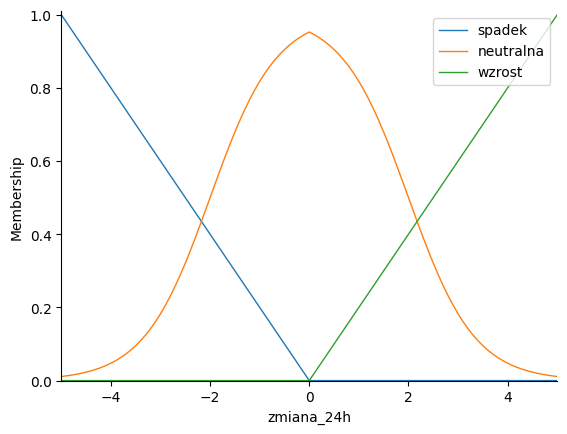

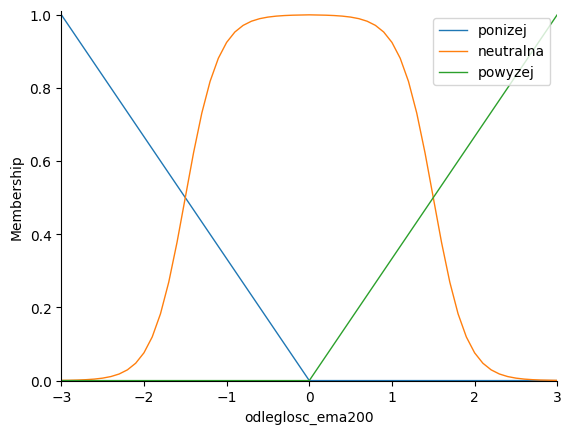

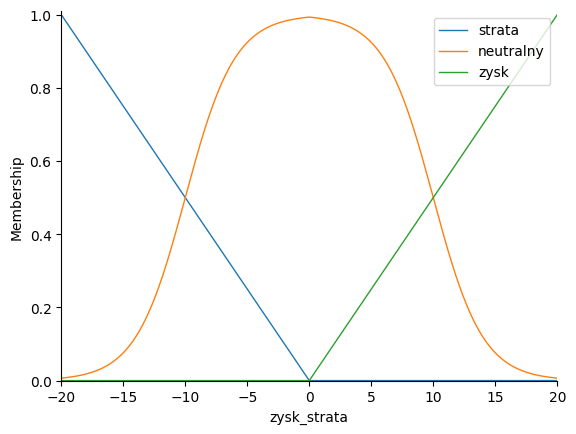

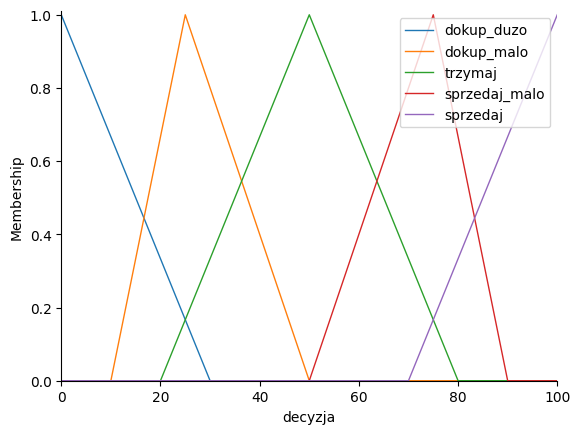

In [5]:
zmiana_24h.view()
plt.xlim(-change_th,change_th)
plt.legend(loc=1)
plt.show()
odleglosc_ema200.view()
plt.xlim(-ema_th,ema_th)
plt.legend(loc=1)
plt.show()
zysk_strata.view()
plt.xlim(-reward_th,reward_th)
plt.legend(loc=1)
plt.show()
decyzja.view()
plt.legend(loc=1)
plt.show()

# Zbiór zasad
dobrany przeze mnie "ekspercko" 

In [6]:
rules = [
    ctrl.Rule(zmiana_24h['spadek'] & odleglosc_ema200['ponizej'] & zysk_strata['strata'], decyzja['dokup_duzo']),
    ctrl.Rule(zmiana_24h['spadek'] & odleglosc_ema200['ponizej'] & zysk_strata['neutralny'], decyzja['dokup_duzo']),
    ctrl.Rule(zmiana_24h['spadek'] & odleglosc_ema200['ponizej'] & zysk_strata['zysk'], decyzja['dokup_malo']),

    ctrl.Rule(zmiana_24h['spadek'] & odleglosc_ema200['neutralna'] & zysk_strata['strata'], decyzja['dokup_duzo']),
    ctrl.Rule(zmiana_24h['spadek'] & odleglosc_ema200['neutralna'] & zysk_strata['neutralny'], decyzja['dokup_malo']),
    ctrl.Rule(zmiana_24h['spadek'] & odleglosc_ema200['neutralna'] & zysk_strata['zysk'], decyzja['trzymaj']),

    ctrl.Rule(zmiana_24h['spadek'] & odleglosc_ema200['powyzej'] & zysk_strata['strata'], decyzja['trzymaj']),
    ctrl.Rule(zmiana_24h['spadek'] & odleglosc_ema200['powyzej'] & zysk_strata['neutralny'], decyzja['trzymaj']),
    ctrl.Rule(zmiana_24h['spadek'] & odleglosc_ema200['powyzej'] & zysk_strata['zysk'], decyzja['sprzedaj_malo']),

    ctrl.Rule(zmiana_24h['neutralna'] & odleglosc_ema200['ponizej'] & zysk_strata['strata'], decyzja['dokup_malo']),
    ctrl.Rule(zmiana_24h['neutralna'] & odleglosc_ema200['ponizej'] & zysk_strata['neutralny'], decyzja['trzymaj']),
    ctrl.Rule(zmiana_24h['neutralna'] & odleglosc_ema200['ponizej'] & zysk_strata['zysk'], decyzja['trzymaj']),

    ctrl.Rule(zmiana_24h['neutralna'] & odleglosc_ema200['neutralna'] & zysk_strata['strata'], decyzja['dokup_malo']),
    ctrl.Rule(zmiana_24h['neutralna'] & odleglosc_ema200['neutralna'] & zysk_strata['neutralny'], decyzja['trzymaj']),
    ctrl.Rule(zmiana_24h['neutralna'] & odleglosc_ema200['neutralna'] & zysk_strata['zysk'], decyzja['trzymaj']),

    ctrl.Rule(zmiana_24h['neutralna'] & odleglosc_ema200['powyzej'] & zysk_strata['strata'], decyzja['trzymaj']),
    ctrl.Rule(zmiana_24h['neutralna'] & odleglosc_ema200['powyzej'] & zysk_strata['neutralny'], decyzja['trzymaj']),
    ctrl.Rule(zmiana_24h['neutralna'] & odleglosc_ema200['powyzej'] & zysk_strata['zysk'], decyzja['sprzedaj_malo']),

    ctrl.Rule(zmiana_24h['wzrost'] & odleglosc_ema200['ponizej'] & zysk_strata['strata'], decyzja['dokup_malo']),
    ctrl.Rule(zmiana_24h['wzrost'] & odleglosc_ema200['ponizej'] & zysk_strata['neutralny'], decyzja['trzymaj']),
    ctrl.Rule(zmiana_24h['wzrost'] & odleglosc_ema200['ponizej'] & zysk_strata['zysk'], decyzja['sprzedaj_malo']),

    ctrl.Rule(zmiana_24h['wzrost'] & odleglosc_ema200['neutralna'] & zysk_strata['strata'], decyzja['trzymaj']),
    ctrl.Rule(zmiana_24h['wzrost'] & odleglosc_ema200['neutralna'] & zysk_strata['neutralny'], decyzja['sprzedaj_malo']),
    ctrl.Rule(zmiana_24h['wzrost'] & odleglosc_ema200['neutralna'] & zysk_strata['zysk'], decyzja['sprzedaj']),

    ctrl.Rule(zmiana_24h['wzrost'] & odleglosc_ema200['powyzej'] & zysk_strata['strata'], decyzja['trzymaj']),
    ctrl.Rule(zmiana_24h['wzrost'] & odleglosc_ema200['powyzej'] & zysk_strata['neutralny'], decyzja['sprzedaj_malo']),
    ctrl.Rule(zmiana_24h['wzrost'] & odleglosc_ema200['powyzej'] & zysk_strata['zysk'], decyzja['sprzedaj']),
]


# Metoda defuzzyfikajcji
używam bazowej 'centroid', bo w scikit learn jest troche bidnie z tym.

In [7]:
decyzja.defuzzify_method = 'centroid'
system = ctrl.ControlSystem(rules)
simulator = ctrl.ControlSystemSimulation(system)

# Przykład użycia

Decyzja: 56.76


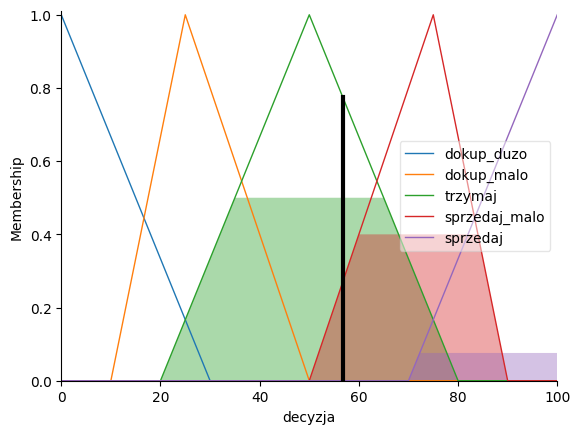

In [8]:
# Przykład: zmiana -1%, EMA -3%, strata -5%
simulator.input['zmiana_24h'] = 2
simulator.input['odleglosc_ema200'] = -2
simulator.input['zysk_strata'] = 10

simulator.compute()
print(f"Decyzja: {simulator.output['decyzja']:.2f}")
decyzja.view(sim=simulator)




## Przykłady z życia wzięte
na przykładzie akcji MOL na dzien 10.05.2025 i mojej pozycji
![alt text](mol.png "Title")
(prosze mi zaufać, że tam jest 6.9% zysku :)

Decyzja: 54.01


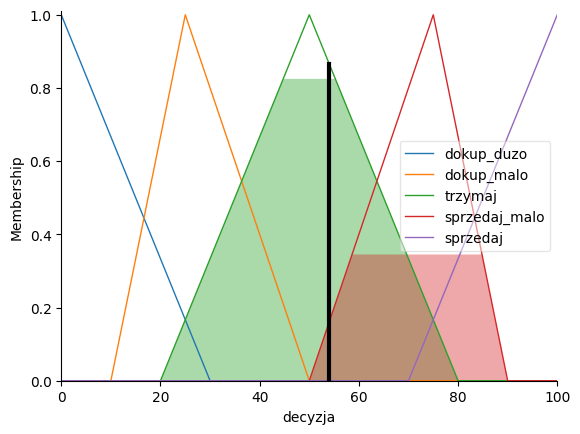

In [9]:
simulator.input['zmiana_24h'] = 0
simulator.input['odleglosc_ema200'] = 3.3
simulator.input['zysk_strata'] = 6.9

simulator.compute()
print(f"Decyzja: {simulator.output['decyzja']:.2f}")
decyzja.view(sim=simulator)

na przykładzie moich akcji PKP
![alt text](PKP.png "Title")


Decyzja: 71.63


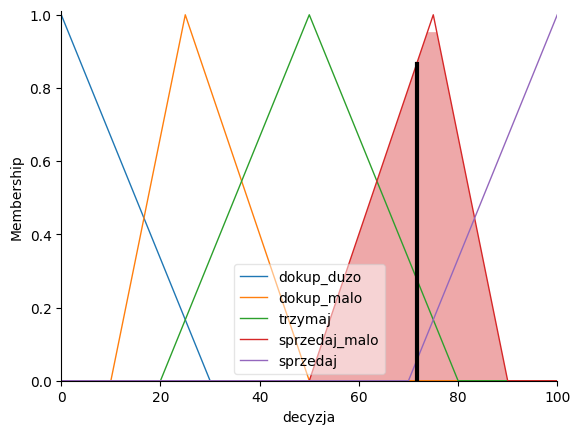

In [10]:
simulator.input['zmiana_24h'] = 0 ## tu tez kolo 0 sie bujamy, robie na weekendzie to nie mam policznoego zysk/strata
simulator.input['odleglosc_ema200'] = 4.2
simulator.input['zysk_strata'] = 25

simulator.compute()
print(f"Decyzja: {simulator.output['decyzja']:.2f}")
decyzja.view(sim=simulator)

#### Okazuje się, że powinienem troche sprzedać

tu SP500, na stracie, przez Pomarańczowego Pana
![alt text](SP500.png "Title")


Decyzja: 49.86


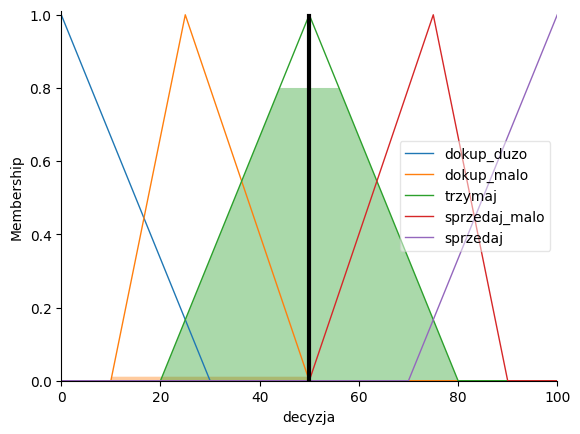

In [11]:
simulator.input['zmiana_24h'] = 0 ## moze cos ciekawszego by sie stalo na otwartym rynku
simulator.input['odleglosc_ema200'] = 2.4
simulator.input['zysk_strata'] = -3.9

simulator.compute()
print(f"Decyzja: {simulator.output['decyzja']:.2f}")
decyzja.view(sim=simulator)

Decyzja: 55.49


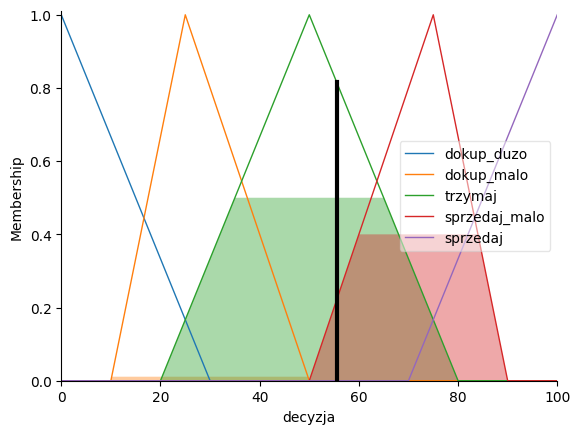

In [13]:
simulator.input['zmiana_24h'] = 2 ## tu dodaje +2% na SP500, zmienia sie decyzyjność o 6 pkt. Dalej to etf to do grobu trzymam hehe
simulator.input['odleglosc_ema200'] = 2.4
simulator.input['zysk_strata'] = -3.9

simulator.compute()
print(f"Decyzja: {simulator.output['decyzja']:.2f}")
decyzja.view(sim=simulator)